In [2]:
%load_ext autoreload
%autoreload 2
%matplotlib inline
%config InlineBackend.figure_format = 'retina'
import networkx as nx
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np

## Introduction

In this chapter, we will analyse the evolution of US Airport Network between 1990 and 2015. This dataset contains data for 25 years[1995-2015] of flights between various US airports and metadata about these routes. Taken from Bureau of Transportation Statistics, United States Department of Transportation.

Let's see what can we make out of this!

In [3]:
from nams import load_data as cf
pass_air_data = cf.load_airports_data()

In the `pass_air_data` dataframe we have the information of number of people that fly every year on a particular route on the list of airlines that fly that route.

In [5]:
pass_air_data.head()

,YEAR,ORIGIN,DEST,UNIQUE_CARRIER_NAME,PASSENGERS
id,,,,,
0,1990,ABE,ACY,{'US Airways Inc.'},73.0
1,1990,ABE,ATL,{'Eastern Air Lines Inc.'},73172.0
2,1990,ABE,AVL,{'Westair Airlines Inc.'},0.0
3,1990,ABE,AVP,"{'Westair Airlines Inc.', 'US Airways Inc.', '...",8397.0
4,1990,ABE,BHM,{'Eastern Air Lines Inc.'},59.0


Every row in this dataset is a unique route between 2 airports in United States territory in a particular year. Let's see how many people flew from New York JFK to Austin in 2006.

NOTE: This will be a fun chapter if you are an aviation geek and like guessing airport IATA codes.

In [6]:
pass_air_data.query('YEAR == 2006').query("ORIGIN == 'JFK' and DEST == 'AUS'")

,YEAR,ORIGIN,DEST,UNIQUE_CARRIER_NAME,PASSENGERS
id,,,,,
215634,2006,JFK,AUS,"{'Shuttle America Corp.', 'Ameristar Air Cargo...",105290.0


From the above pandas query we see that according to this dataset 105290 passengers travelled from JFK to AUS in the year 2006.

But how does this dataset translate to an applied network analysis problem? In the previous chapter we created different graph objects for every book. Let's create a graph object which encompasses all the edges.

NetworkX provides us with Multi(Di)Graphs to model networks with multiple edges between two nodes.

In this case every row in the dataframe represents a directed edge between two airports, common sense suggests that if there is a flight from airport A to airport B there should definitely be a flight from airport B to airport A, i.e direction of the edge shouldn't matter. But in this dataset we have data for individual directions (A -> B and B -> A) so we create a MultiDiGraph.

In [7]:
passenger_graph = nx.from_pandas_edgelist(pass_air_data, source='ORIGIN', target='DEST',
                                          edge_attr=['YEAR', 'PASSENGERS', 'UNIQUE_CARRIER_NAME'],
                                          create_using=nx.MultiDiGraph())

We have created a MultiDiGraph object `passenger_graph` which contains all the information from the dataframe `pass_air_data`.

Let's check if can access the same information (the 2006 route between JFK and AUS) using our `passenger_graph`.

In [8]:
passenger_graph['JFK']['AUS'][2006]

KeyError: 2006

Hmmm, What happened here? This should have given us the data right? Currently the way the NetworkX reads in pandas edgelist we can't control the edge_keys in Multi(Di)Graphs. So we need to manually iterate through the edges and find our desired edge.

In [16]:
for edge in passenger_graph['JFK']['AUS']:
    if passenger_graph['JFK']['AUS'][edge]['YEAR'] == 2006:
        print(passenger_graph['JFK']['AUS'][edge])

{'YEAR': 2006, 'PASSENGERS': 105290.0, 'UNIQUE_CARRIER_NAME': "{'Shuttle America Corp.', 'Ameristar Air Cargo', 'JetBlue Airways', 'United Parcel Service'}"}


Now let's use our new constructed passenger graph to look at the evolution of passenger load over 25 years.

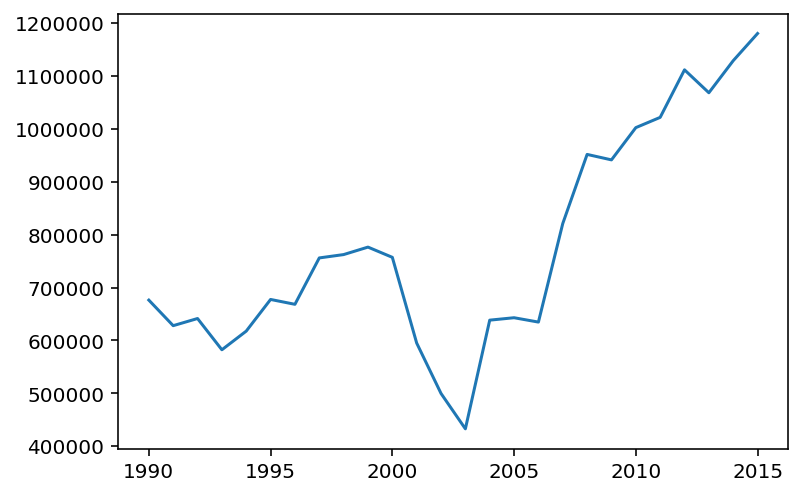

In [17]:
# Route betweeen New York-JFK and SFO

values = [(edge['YEAR'],
           edge['PASSENGERS'])
          for edge in dict(passenger_graph['JFK']['SFO']).values()]
x, y = zip(*values)
plt.plot(x, y)
plt.show()

We see some usual trends all across the datasets like steep drops in 2001 (after 9/11) and 2008 (recession)

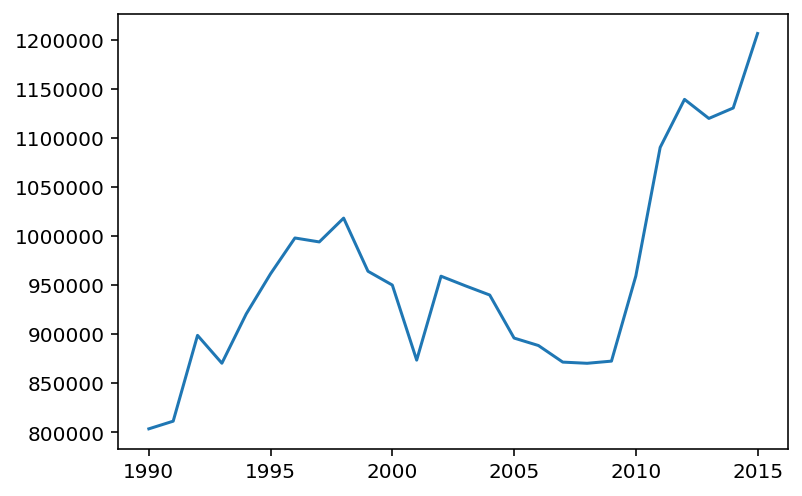

In [18]:
# Route betweeen SFO and Chicago

values = [(edge['YEAR'],
           edge['PASSENGERS'])
          for edge in dict(passenger_graph['SFO']['ORD']).values()]
x, y = zip(*values)
plt.plot(x, y)
plt.show()

To find the overall trend, we can use our `pass_air_data` dataframe to calculate total passengers flown in a year.

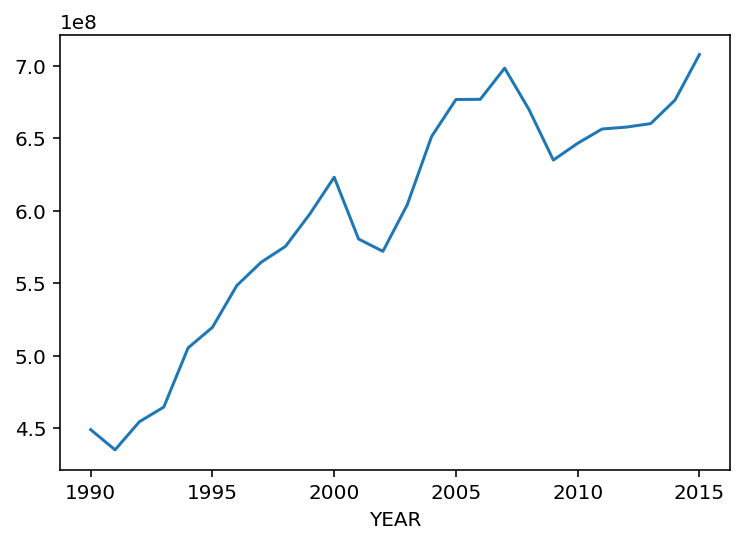

In [19]:
pass_air_data.groupby(['YEAR']).sum()['PASSENGERS'].plot()
plt.show()

### Exercise

Find the busiest route in 1990 and in 2015 according to number of passengers, and plot the time series of number of passengers on these routes.

You can use the DataFrame instead of working with the network. It will be faster :)

In [20]:
from nams.solutions.airport import busiest_route, plot_time_series

ModuleNotFoundError: No module named 'nams'

In [21]:
busiest_route(pass_air_data, 1990)

,YEAR,ORIGIN,DEST,UNIQUE_CARRIER_NAME,PASSENGERS
id,,,,,
3917,1990,LAX,HNL,"{'Heavylift Cargo Airlines Lt', 'Hawaiian Airl...",1827164.0


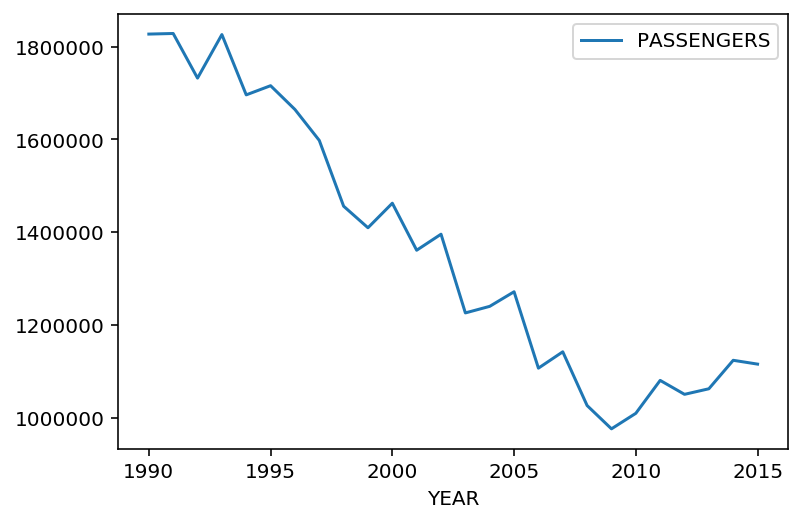

In [22]:
plot_time_series(pass_air_data, 'LAX', 'HNL')

In [23]:
busiest_route(pass_air_data, 2015)

,YEAR,ORIGIN,DEST,UNIQUE_CARRIER_NAME,PASSENGERS
id,,,,,
445978,2015,LAX,SFO,"{'Hawaiian Airlines Inc.', 'Delta Air Lines In...",1869066.0


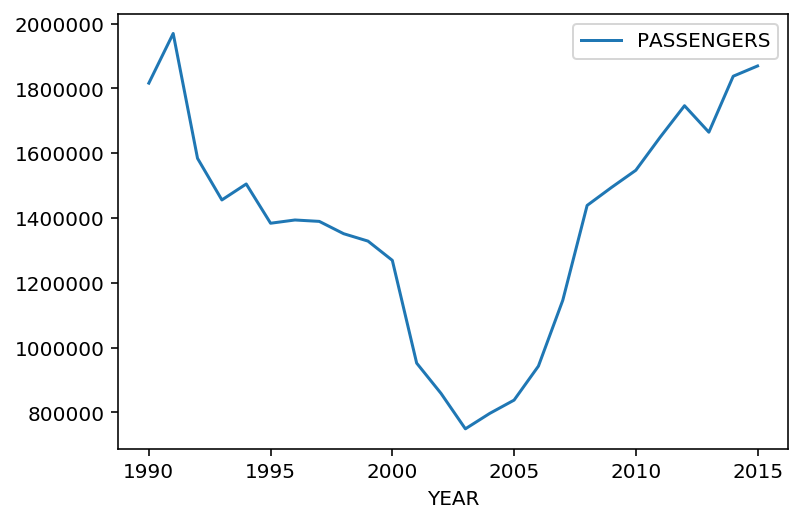

In [24]:
plot_time_series(pass_air_data, 'LAX', 'SFO')

Before moving to the next part of the chapter let's create a method to extract edges from `passenger_graph` for a particular year so we can better analyse the data on a granular scale.

In [271]:
def year_network(G, year):
    """ Extract edges for a particular year from
        a MultiGraph. The edge is also populated with
        two attributes, weight and weight_inv where
        weight is the number of passengers and
        weight_inv the inverse of it.
    """
    year_network = nx.DiGraph()
    for edge in G.edges(data=True):
        if edge[2]['YEAR'] == year:
            year_network.add_edge(edge[0],
                                  edge[1],
                                  weight=edge[2]['PASSENGERS'],
                                  weight_inv=1/(edge[2]['PASSENGERS'] if edge[2]['PASSENGERS'] != 0.0 else 1),
                                  airlines=edge[2]['UNIQUE_CARRIER_NAME'])
    return year_network

In [272]:
pass_2015_network = year_network(passenger_graph, 2015)

In [128]:
# We have extracted a Directed Graph from the Multi Directed Graph
# Number of nodes = airports
# Number of edges = routes

print(nx.info(pass_2015_network))

Name: 
Type: DiGraph
Number of nodes: 1258
Number of edges: 25354
Average in degree:  20.1542
Average out degree:  20.1542


## Visualise the airports

In [129]:
# Loadin the GPS coordinates of all the airports
from nams import load_data as cf
lat_long = cf.load_airports_GPS_data()

In [130]:
# Dictionary to store position corrdinates from the dataset
pos_dict = {}
for airport in lat_long[lat_long[1].isin(list(pass_2015_network.nodes()))].iterrows():
    pos_dict[airport[1][1]] = (airport[1][15], airport[1][14]) 

In [131]:
# NOTE: This GPS dataset doesn't contain GPS coordinates for all the airports in our network
len(pos_dict)

363

Let's first plot only the nodes, i.e airports. Places like Guam, US Virgin Islands are also included in this dataset as they are treated as domestic airports in this dataset.

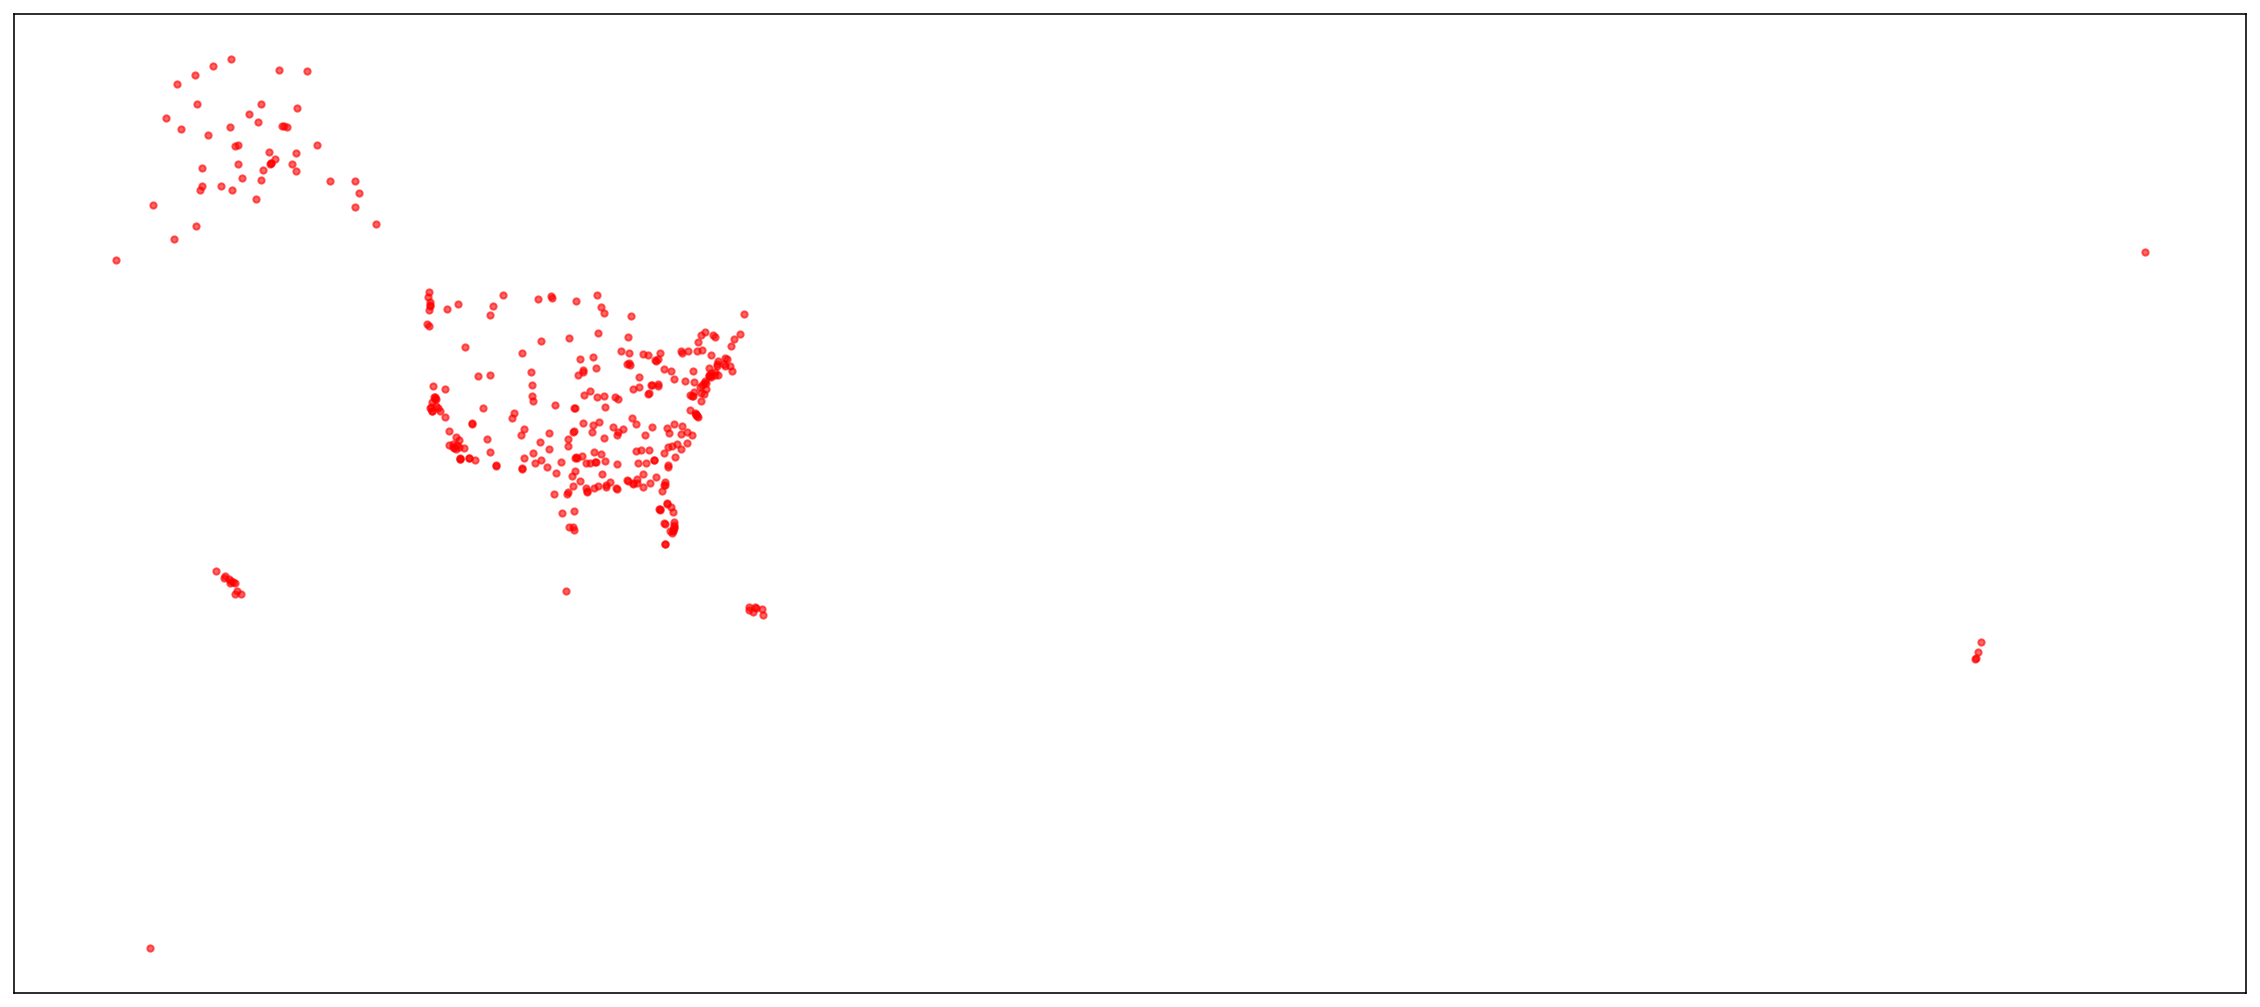

In [132]:
plt.figure(figsize=(20, 9))
# We take a subgraph view as we don't have the GPS coordinates for all the airports
G = nx.subgraph(pass_2015_network, pos_dict.keys())
nx.draw_networkx_nodes(G, pos=pos_dict, node_size=10, alpha=0.6, node_color='r')
# nx.draw_networkx_edges(G, pos=pos_dict, width=0.1, arrows=False)
plt.show()

We can get the above plot also be just using a scatter plot of the GPS coordinates

``` python
x = [GPS[0] for GPS in pos_dict.values()]
y = [GPS[1] for GPS in pos_dict.values()]
plt.scatter(x, y)
```

Let's also plot the routes(edges).

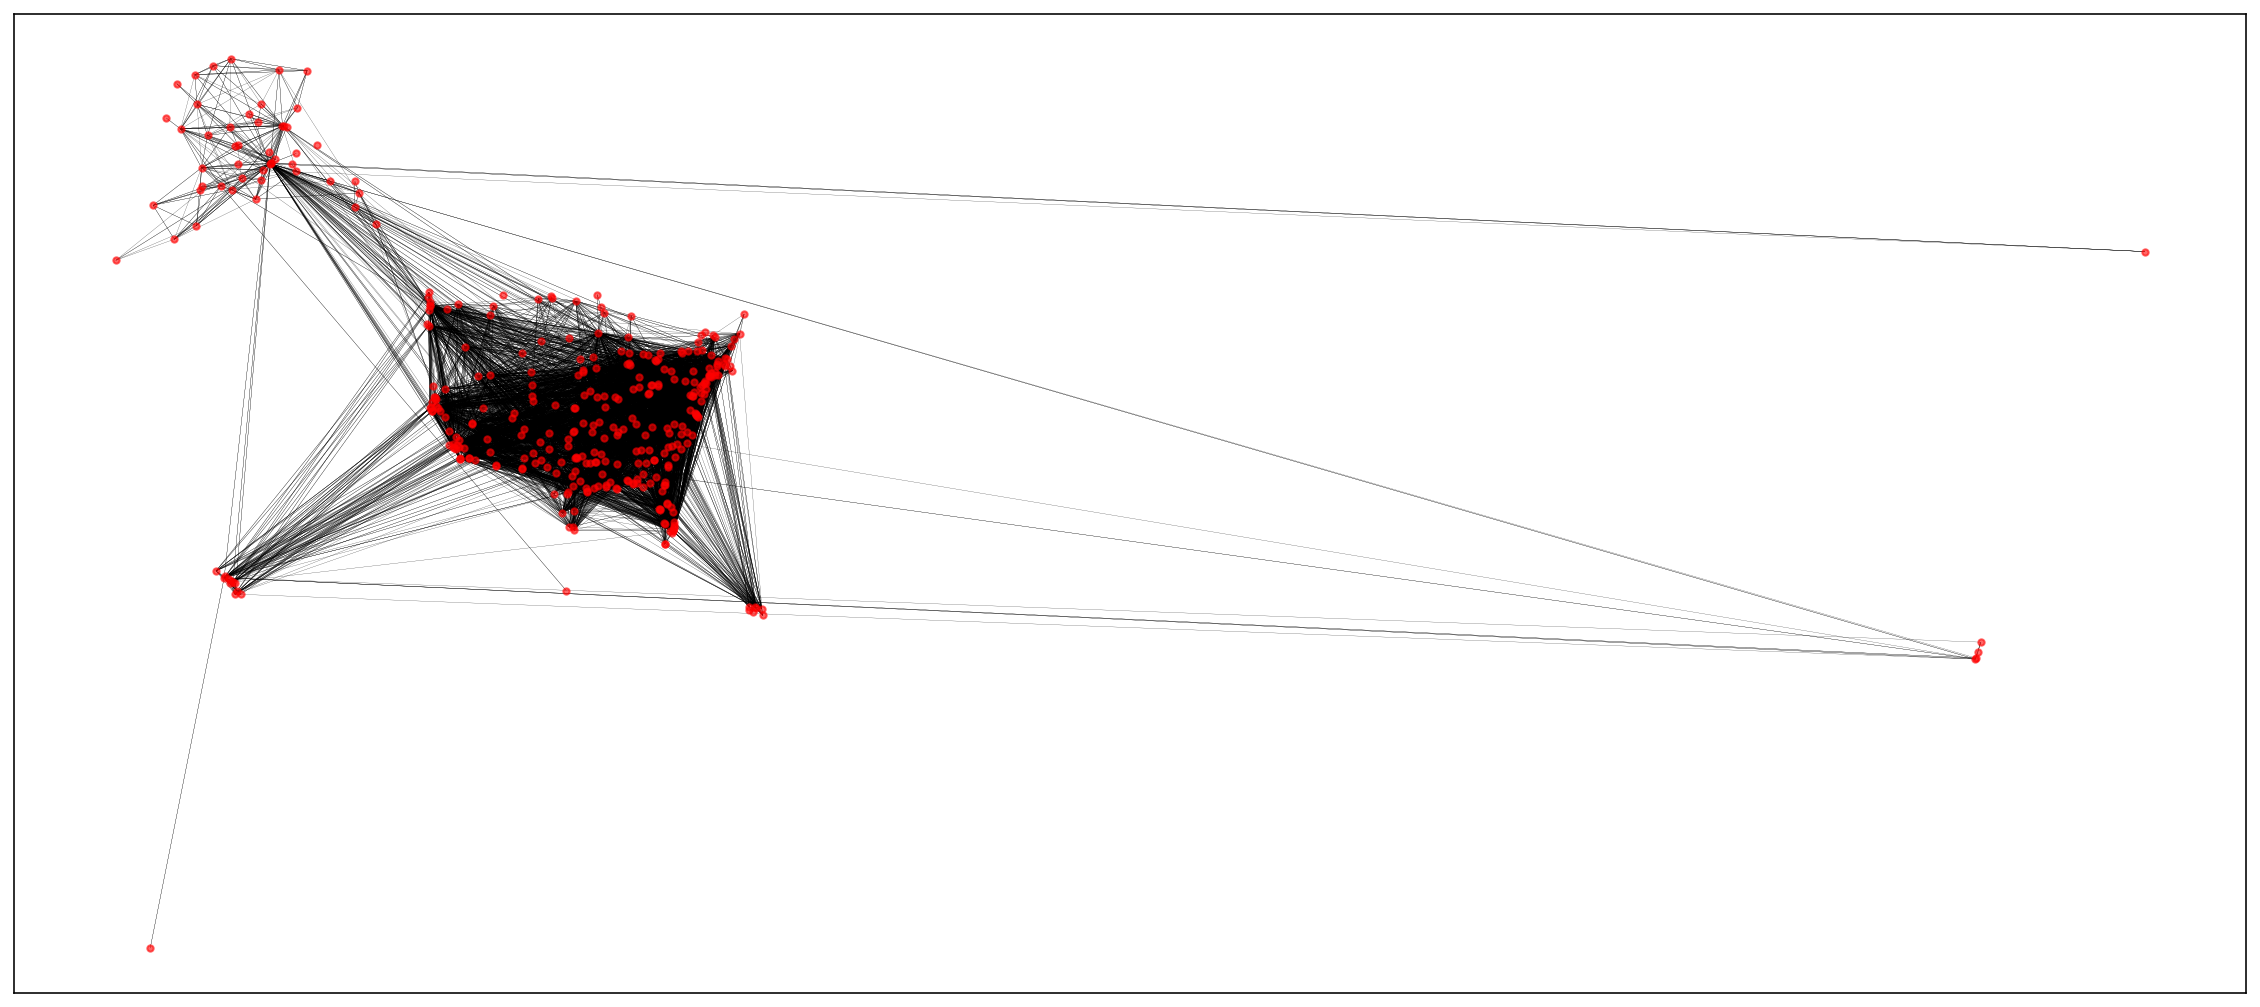

In [133]:
plt.figure(figsize=(20, 9))
# We take a subgraph view as we don't have the GPS coordinates for all the airports
G = nx.subgraph(pass_2015_network, pos_dict.keys())
nx.draw_networkx_nodes(G, pos=pos_dict, node_size=10, alpha=0.6, node_color='r')
nx.draw_networkx_edges(G, pos=pos_dict, width=0.1, arrows=False)
plt.show()

Before we proceed further, let's take a detour to briefly discuss directed networks and PageRank.

## Directed Graphs and PageRank

The figure below explains the basic idea behind the PageRank algorithm. The "importance" of the node depends on the incoming links to the node, i.e if an "important" node A points towards a node B it will increase the PageRank score of node B, and this is run iteratively. In the given figure, even though node C is only connected to one node it is considered "important" as the connection is to node B, which is an "important" node.

<!-- ![](images/pagerank.png) -->
<img src="images/pagerank.png" alt="pagerank" width="500"/>

Source: Wikipedia

To better understand this let's work through an example.

In [134]:
# Create an empty directed graph object
G = nx.DiGraph()
# Add an edge from 1 to 2 with weight 4
G.add_edge(1, 2, weight=4)

In [135]:
print(G.edges(data=True))

[(1, 2, {'weight': 4})]


In [136]:
# Access edge from 1 to 2
G[1][2]

{'weight': 4}

In [137]:
# Access edge from 2 to 1
G[2][1]

KeyError: 1

As expected we get an error when we try to access the edge between 2 to 1 as this is a directed graph.

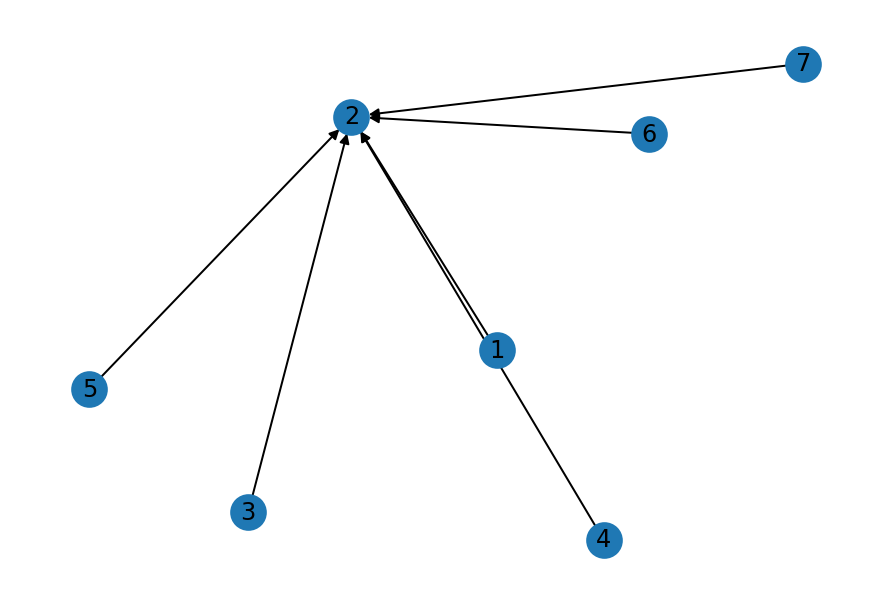

In [138]:
G.add_edges_from([(1, 2), (3, 2), (4, 2), (5, 2), (6, 2), (7, 2)])
nx.draw_spring(G, with_labels=True)

Just by looking at the example above, we can conclude that node 2 should have the highest PageRank score as all the nodes are pointing towards it.

This is confirmed by calculating the PageRank of this graph.

In [139]:
nx.pagerank(G)

{1: 0.0826448180198328,
 2: 0.5041310918810031,
 3: 0.0826448180198328,
 4: 0.0826448180198328,
 5: 0.0826448180198328,
 6: 0.0826448180198328,
 7: 0.0826448180198328}

What happens when we add an edge from node 5 to node 6.

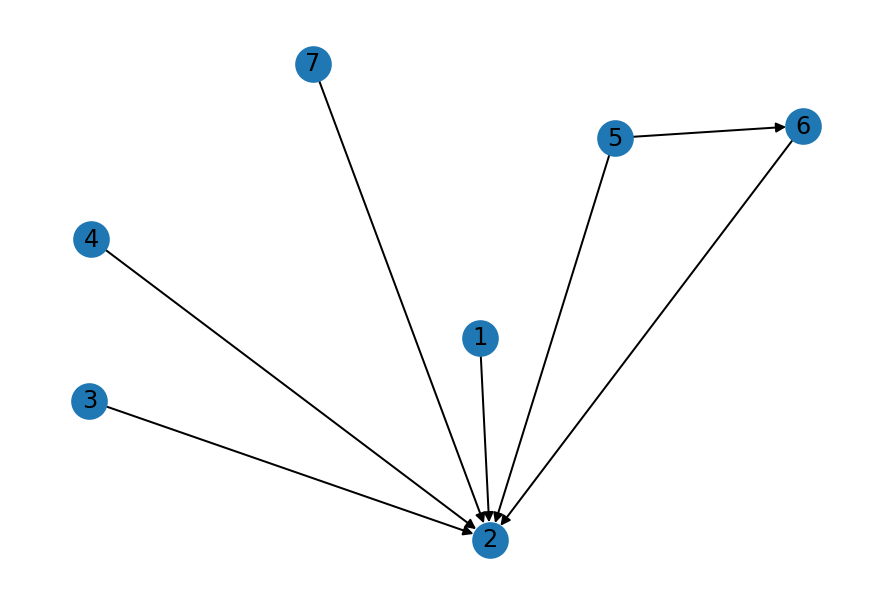

In [140]:
G.add_edge(5, 6)
nx.draw_spring(G, with_labels=True)

In [141]:
nx.pagerank(G)

{1: 0.08024854052495894,
 2: 0.4844028780560986,
 3: 0.08024854052495894,
 4: 0.08024854052495894,
 5: 0.08024854052495894,
 6: 0.11435441931910648,
 7: 0.08024854052495894}

As expected there was some change in the scores (an increase for 6) but the overall trend stays the same, with node 2 leading the pack.

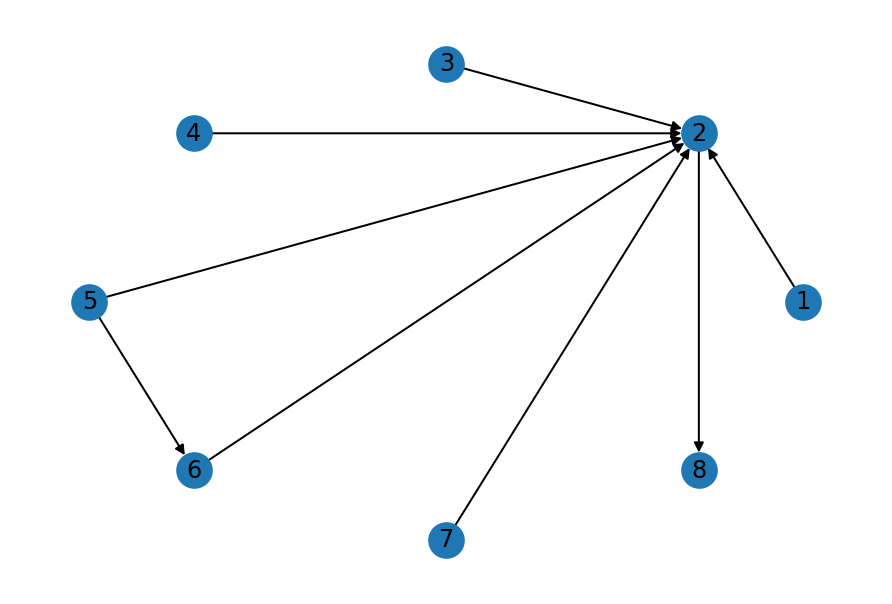

In [142]:
G.add_edge(2, 8)
nx.draw_circular(G, with_labels=True)

Now we have an added an edge from 2 to a new node 8. As node 2 already has a high PageRank score, this should be passed on node 8. Let's see how much difference this can make.

In [143]:
nx.pagerank(G)

{1: 0.05378612718073915,
 2: 0.3246687852772877,
 3: 0.05378612718073915,
 4: 0.05378612718073915,
 5: 0.05378612718073915,
 6: 0.0766454192258098,
 7: 0.05378612718073915,
 8: 0.3297551595932067}

In this example, node 8 is now even more "important" than node 2 even though node 8 has only incoming connection.

Let's move back to Airports and use this knowledge to analyse the network.

## Importants Hubs in the Airport Network

So let's have a look at the important nodes in this network, i.e. important airports in this network. We'll use centrality measures like pagerank, betweenness centrality and degree centrality which we gone through in this book.

In [144]:
# Let's try to calulate the PageRank measures of this graph.
nx.pagerank(passenger_graph)

NetworkXNotImplemented: not implemented for multigraph type

As PageRank isn't defined for a MultiGraph in NetworkX so we need to use our extracted yearly sub networks.

In [145]:
# As pagerank will take weighted measure by default we pass in
# None to make this calculation for unweighted network
PR_2015_scores = nx.pagerank(pass_2015_network, weight=None)

In [146]:
# Let's check the PageRank score for JFK
PR_2015_scores['JFK']

0.0036376572979606586

In [147]:
# top 10 airports according to unweighted PageRank
top_10_pr = sorted(PR_2015_scores.items(), key=lambda x:x[1], reverse=True)[:10]

In [148]:
# top 10 airports according to unweighted betweenness centrality
top_10_bc = sorted(nx.betweenness_centrality(pass_2015_network,
                                             weight=None).items(), key=lambda x:x[1], reverse=True)[0:10]

In [149]:
# top 10 airports according to degree centrality
top_10_dc = sorted(nx.degree_centrality(pass_2015_network).items(), key=lambda x:x[1], reverse=True)[0:10]

Before looking at the results do think about what we just calculated and try to guess which airports should come out at the top and be ready to be surprised :D

In [150]:
# PageRank
top_10_pr

[('ANC', 0.010425531156396332),
 ('HPN', 0.008715287139161587),
 ('FAI', 0.007865131822111036),
 ('DFW', 0.007168038232113773),
 ('DEN', 0.006557279519803018),
 ('ATL', 0.006367579588749718),
 ('ORD', 0.006178836107660135),
 ('YIP', 0.005821525504523931),
 ('ADQ', 0.005482597083474197),
 ('MSP', 0.005481962582230961)]

In [151]:
# Betweenness Centrality
top_10_bc

[('ANC', 0.28907458480586606),
 ('FAI', 0.08042857784594384),
 ('SEA', 0.06745549919241699),
 ('HPN', 0.06046810178534726),
 ('ORD', 0.045544143864829294),
 ('ADQ', 0.040170160000905696),
 ('DEN', 0.038543251364241436),
 ('BFI', 0.03811277548952854),
 ('MSP', 0.03774809342340624),
 ('TEB', 0.036229439542316354)]

In [152]:
# Degree Centrality
top_10_dc

[('ATL', 0.3643595863166269),
 ('ORD', 0.354813046937152),
 ('DFW', 0.3420843277645187),
 ('MSP', 0.3261734287987271),
 ('DEN', 0.31821797931583135),
 ('ANC', 0.3046937151949085),
 ('MEM', 0.29196499602227527),
 ('LAX', 0.2840095465393795),
 ('IAH', 0.28082736674622116),
 ('DTW', 0.27446300715990457)]

The Degree Centrality results do make sense at first glance, ATL is Atlanta, ORD is Chicago, these are defintely airports one would expect to be at the top of a list which calculates "importance" of an airport. But when we look at PageRank and Betweenness Centrality we have an unexpected airport 'ANC'. Do think about measures like PageRank and Betweenness Centrality and what they calculate. Do note that currently we have used the core structure of the network, no other metadata like number of passengers. These are calculations on the unweighted network.

'ANC' is the airport code of Anchorage airport, a place in Alaska, and according to pagerank and betweenness centrality it is the most important airport in this network. Isn't that weird? Thoughts?

Looks like 'ANC' is essential to the core structure of the network, as it is the main airport connecting Alaska with other parts of US. This explains the high Betweenness Centrality score and there are flights from other major airports to 'ANC' which explains the high PageRank score.

Related blog post: https://toreopsahl.com/2011/08/12/why-anchorage-is-not-that-important-binary-ties-and-sample-selection/

Let's look at weighted version, i.e taking into account the number of people flying to these places.

In [153]:
# Recall from the last chapter we use weight_inv while calculating
# betweenness centrality
sorted(nx.betweenness_centrality(pass_2015_network,
                                 weight='weight_inv').items(),
       key=lambda x:x[1], reverse=True)[0:10]

[('SEA', 0.4192179843829966),
 ('ATL', 0.3589665389741017),
 ('ANC', 0.32425767084369994),
 ('LAX', 0.2668567170342895),
 ('ORD', 0.10008664852621497),
 ('DEN', 0.0964658422388763),
 ('MSP', 0.09300021788810685),
 ('DFW', 0.0926644126226465),
 ('FAI', 0.08824779747216016),
 ('BOS', 0.08259764427486331)]

In [156]:
sorted(nx.pagerank(pass_2015_network, weight='weight').items(), key=lambda x:x[1], reverse=True)[0:10]

[('ATL', 0.037535963029303135),
 ('ORD', 0.028329766122739346),
 ('SEA', 0.028274564067008245),
 ('ANC', 0.027127866647567035),
 ('DFW', 0.02570050418889442),
 ('DEN', 0.025260024346433315),
 ('LAX', 0.02394043498608451),
 ('PHX', 0.018373176636420224),
 ('CLT', 0.01780703930063076),
 ('LAS', 0.017649683141049966)]

When we adjust for number of passengers we see that we have a reshuffle in the "importance" rankings, and they do make a bit more sense now. According to weighted PageRank, Atlanta, Chicago, Seattle the top 3 airports while Anchorage is at 4th rank now.

To get an even better picture of this we should do the analyse with more metadata about the routes not just the number of passengers.

## How reachable is this network?

Let's assume you are the Head of Data Science of an airline and your job is to make your airline network as "connected" as possible.

To translate this problem statement to network science, we calculate the average shortest path length of this network, it gives us an idea about the number of jumps we need to make around the network to go from one airport to any other airport in this network on average.

In [157]:
nx.average_shortest_path_length(pass_2015_network)

NetworkXError: Graph is not weakly connected.

Wait, What? This network is not "connected" (ignore the term weakly for the moment). That seems weird. It means that there are nodes which aren't reachable from other set of nodes, which isn't good news in especially a transporation network.

Let's have a look at these far flung airports which aren't reachable.

In [160]:
components = list(nx.weakly_connected_components(pass_2015_network))

In [162]:
# There are 3 weakly connected components in the network.
for c in components:
    print(len(c))

1255
2
1


In [164]:
# Let's look at the component with 2 and 1 airports respectively.
print(components[1])
print(components[2])

{'SSB', 'SPB'}
{'AIK'}


The airports 'SSB' and 'SPB' are codes for Seaplanes airports and they have flights to each other so it makes sense that they aren't connected to the larger network of airports.

The airport is even more weird as it is in a component in itself, i.e there is a flight from AIK to AIK. After investigating further it just seems like an anomaly in this dataset.

In [167]:
pass_air_data[(pass_air_data['YEAR'] == 2015) & (pass_air_data['DEST'] == 'AIK')]

,YEAR,ORIGIN,DEST,UNIQUE_CARRIER_NAME,PASSENGERS
id,,,,,
433338,2015,AIK,AIK,{'Wright Air Service'},0.0


In [168]:
# Let's get rid of them, we don't like them
pass_2015_network.remove_nodes_from(['SPB', 'SSB', 'AIK'])

In [169]:
# Our network is weakly connected now
nx.is_weakly_connected(pass_2015_network)

True

In [171]:
# It's not strongly connected
nx.is_strongly_connected(pass_2015_network)

False

### Strongly vs weakly connected graphs.

Let's go through an example to understand weakly and strongly connected directed graphs.

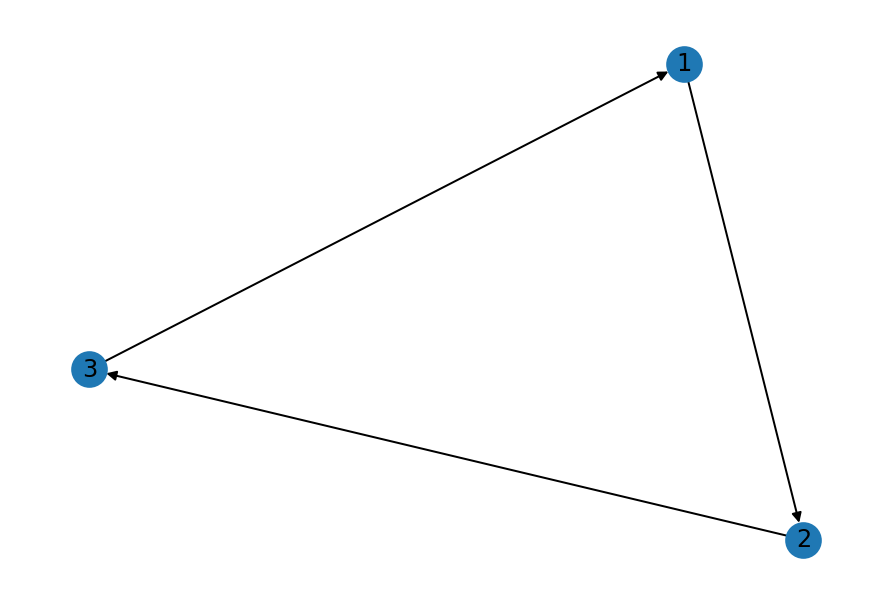

In [188]:
# NOTE: The notion of strongly and weakly exists only for directed graphs.
G = nx.DiGraph()

# Let's create a cycle directed graph, 1 -> 2 -> 3 -> 1
G.add_edge(1, 2)
G.add_edge(2, 3)
G.add_edge(3, 1)
nx.draw(G, with_labels=True)

In the above example we can reach any node irrespective of where we start traversing the network, if we start from 2 we can reach 1 via 3. In this network every node is "reachable" from one another, i.e the network is strongly connected.

In [191]:
nx.is_strongly_connected(G)

True

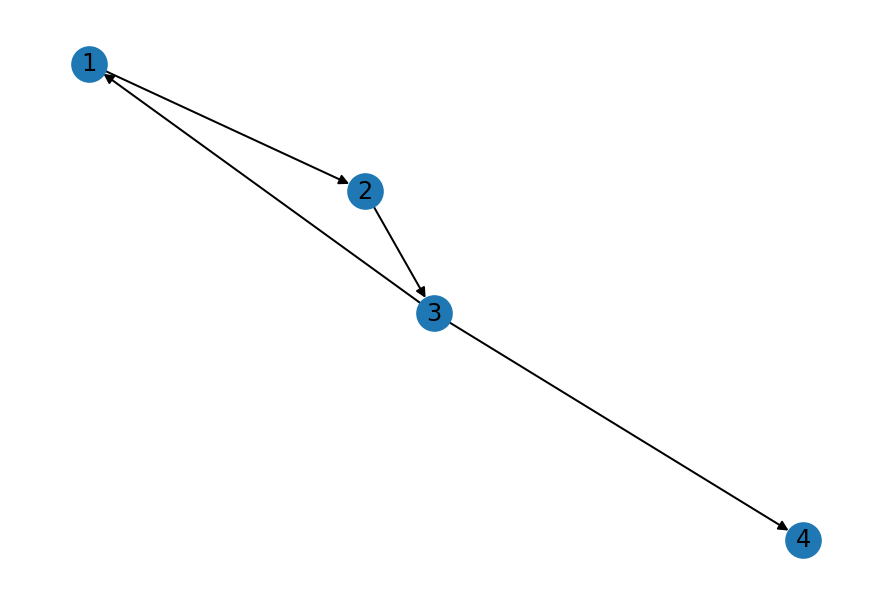

In [192]:
# Let's add a new connection
G.add_edge(3, 4)
nx.draw(G, with_labels=True)

It's evident from the example above that we *can't* traverse the network graph. If we start from node 4 we are stuck at the node, we don't have any way of leaving node 4. This is assuming we strictly follow the direction of edges. In this case the network isn't strongly connected but if we look at the structure and assume the directions of edges don't matter than we can go to any other node in the network even if we start from node 4.

In the case an undirected copy of directed network is connected we call the directed network as weakly connected.

In [193]:
nx.is_strongly_connected(G)

False

In [194]:
nx.is_weakly_connected(G)

True

Let's go back to our airport network of 2015.

After removing those 3 airports the network is weakly connected.

In [203]:
nx.is_weakly_connected(pass_2015_network)

True

In [204]:
nx.is_strongly_connected(pass_2015_network)

False

But our network is still not strongly connected, which essentially means there are airports in the network where you can fly into but not fly back, which doesn't really seem okay

In [206]:
strongly_connected_components = list(nx.strongly_connected_components(pass_2015_network))

In [211]:
# Let's look at one of the examples of a strong connected component
strongly_connected_components[0]

{'BCE'}

In [216]:
pass_air_data[(pass_air_data['YEAR'] == 2015) & (pass_air_data['DEST'] == 'BCE')]

,YEAR,ORIGIN,DEST,UNIQUE_CARRIER_NAME,PASSENGERS
id,,,,,
451074,2015,PGA,BCE,"{'Grand Canyon Airlines, Inc. d/b/a Grand Cany...",8.0


In [217]:
pass_air_data[(pass_air_data['YEAR'] == 2015) & (pass_air_data['ORIGIN'] == 'BCE')]

,YEAR,ORIGIN,DEST,UNIQUE_CARRIER_NAME,PASSENGERS
id,,,,,


As we can see above you can fly into 'BCE' but can't fly out, weird indeed. These airport are small airports with one off schedules flights. For the purposes of our analyses we can ignore such airports.

In [228]:
# Let's find the biggest strongly connected component
pass_2015_strong_nodes = max(strongly_connected_components, key=len)

In [233]:
# Create a subgraph with the nodes in the biggest strongly connected component
pass_2015_network_strong = pass_2015_network.subgraph(nodes=pass_2015_strong_nodes)

In [234]:
nx.is_strongly_connected(pass_2015_network_strong)

True

After removing multiple airports we now have a strongly connected airport network. We can now travel from one airport to any other airport in the network.

In [235]:
# We started with 1258 airports
len(pass_2015_network_strong)

1190

In [236]:
nx.average_shortest_path_length(pass_2015_network_strong)

3.174661992635574

The 3.17 number above represents the average length between 2 airports in the network which means that it's possible to go from one airport to another in this network under 3 layovers, which sounds nice. A more reachable network is better, not necessearily in terms of revenue for the airline but for social health of the air transport network.

### Exercise

How can we decrease the average shortest path length of this network?

Think of an effective way to add new edges to decrease the average shortest path length.
Let's see if we can come up with a nice way to do this.

The rules are simple:
- You can't add more than 2% of the current edges( ~500 edges)

In [250]:
from nams.solutions.airport import add_opinated_edges

ModuleNotFoundError: No module named 'nams'

In [251]:
new_routes_network = add_opinated_edges(pass_2015_network_strong)

In [249]:
nx.average_shortest_path_length(new_routes_network)

3.0888508809747615

Using an opinionated heuristic we were able to reduce the average shortest path length of the network. Check the solution below to understand the idea behind the heuristic, do try to come up with your own heuristics.

## Can we find airline specific reachability?

Let's see how we can use the airline metadata to calculate the reachability of a specific airline.

In [277]:
# We have access to the airlines that fly the route in the edge attribute airlines
pass_2015_network['JFK']['SFO']

{'weight': 1179941.0,
 'weight_inv': 8.4750000211875e-07,
 'airlines': "{'Delta Air Lines Inc.', 'Virgin America', 'American Airlines Inc.', 'Sun Country Airlines d/b/a MN Airlines', 'JetBlue Airways', 'Vision Airlines', 'United Air Lines Inc.'}"}

In [288]:
# A helper function to extract the airlines names from the edge attribute
def str_to_list(a):
    return a[1:-1].split(', ')

In [289]:
for origin, dest in pass_2015_network.edges():
    pass_2015_network[origin][dest]['airlines_list'] = str_to_list(
        (pass_2015_network[origin][dest]['airlines']))

Let's extract the network of United Airlines from our airport network.

In [292]:
united_network = nx.DiGraph()
for origin, dest in pass_2015_network.edges():
    if "'United Air Lines Inc.'" in pass_2015_network[origin][dest]['airlines_list']:
            united_network.add_edge(origin, dest, weight=pass_2015_network[origin][dest]['weight'])

In [295]:
# number of nodes -> airports
# number of edges -> routes
print(nx.info(united_network))

Name: 
Type: DiGraph
Number of nodes: 194
Number of edges: 1894
Average in degree:   9.7629
Average out degree:   9.7629


In [296]:
# Let's find United Hubs according to PageRank
sorted(nx.pagerank(united_network, weight='weight').items(), key=lambda x:x[1], reverse=True)[0:5]

[('ORD', 0.08385772266571424),
 ('DEN', 0.06816244850418422),
 ('LAX', 0.053065234147240105),
 ('IAH', 0.044410609028379185),
 ('SFO', 0.04326197030283029)]

In [298]:
# Let's find United Hubs according to Degree Centrality
sorted(nx.degree_centrality(united_network).items(), key=lambda x:x[1], reverse=True)[0:5]

[('ORD', 1.0),
 ('IAH', 0.9274611398963731),
 ('DEN', 0.8756476683937824),
 ('EWR', 0.8134715025906736),
 ('SFO', 0.6839378238341969)]

## Solutions

Here are the solutions to the exercises above.

In [ ]:
from nams.solutions import airport
import inspect

print(inspect.getsource(airport))